## EVP 



In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr

# %% Project bootstrap (root, imports, editable install)
from pathlib import Path
import sys, os, subprocess, importlib.util

def find_project_root(start: Path) -> Path:
    """Walk up until we see a project marker (pyproject.toml, .git, or defaults.yaml)."""
    p = start.resolve()
    markers = {"pyproject.toml", ".git", "defaults.yaml"}
    while p != p.parent:
        if any((p / m).exists() for m in markers):
            return p
        p = p.parent
    return start.resolve()

# works for both .ipynb (no __file__) and .py notebooks
_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    """Install `-e .` iff the import isn't present or doesn't point to this repo."""
    spec = importlib.util.find_spec(pkg_name)
    if not spec or not getattr(spec, "origin", None):
        need_install = True
    else:
        # e.g. .../diffinst/__init__.py  → compare parent (package dir) to repo path
        pkg_path = Path(spec.origin).resolve().parent
        need_install = not pkg_path.samefile(pkg_dir.resolve())
    if need_install:
        print(f"Installing {pkg_name} in editable mode from {ROOT} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(ROOT)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

# now imports are safe and point to this repo
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k

# handy paths
EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "diffinst.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


In [28]:
# %% parameter grids and EVP sweep (clean version)

from dataclasses import replace

cfg_base = Config.from_yaml(EXP_UNSTABLE, DEFAULTS)

# tau_s on x-axis
tau_vals  = np.logspace(-3, 2, 60)   # 10^-3 ... 10^2
beta_vals = np.linspace(-4.0, 2.0, 60)

print("tau_s range:", tau_vals[0], "→", tau_vals[-1])
print("beta_diff range:", beta_vals[0], "→", beta_vals[-1])

# k-grid to search over
kmin, kmax, nk = 10.0, 1e3, 120
k_vals = np.logspace(np.log10(kmin), np.log10(kmax), nk)

def sweep_k_for_cfg(cfg: Config, k_vals):
    gammas = np.empty_like(k_vals)
    for i, k in enumerate(k_vals):
        w, _ = evp_solve_at_k(cfg, float(k))
        gammas[i] = w[0].real
    imax = int(np.argmax(gammas))
    gamma_max = gammas[imax]
    if gamma_max <= 0.0:
        return gamma_max, np.nan
    return gamma_max, float(k_vals[imax])

ny = len(beta_vals)
nx = len(tau_vals)

gamma_maps = np.full((4, ny, nx), np.nan)
kmax_maps  = np.full((4, ny, nx), np.nan)

D0_base = float(cfg_base.D_0)

for j, beta in enumerate(beta_vals):
    for i, tau in enumerate(tau_vals):

        # Panel 0: Sc = 0  (nu_0 = 0)
        cfg0 = replace(cfg_base,
                       ts=float(tau),
                       beta_diff=float(beta),
                       beta_visc=0.0,
                       D_0=D0_base,
                       nu_0=0.0)
        g0, k0 = sweep_k_for_cfg(cfg0, k_vals)
        gamma_maps[0, j, i] = g0
        kmax_maps[0, j, i]  = k0

        # Panel 1: Sc = 1, beta_visc = beta_diff
        cfg1 = replace(cfg_base,
                       ts=float(tau),
                       beta_diff=float(beta),
                       beta_visc=float(beta),
                       D_0=D0_base,
                       nu_0=D0_base)
        g1, k1 = sweep_k_for_cfg(cfg1, k_vals)
        gamma_maps[1, j, i] = g1
        kmax_maps[1, j, i]  = k1

        # Panel 2: Sc = 1, beta_visc = 0
        cfg2 = replace(cfg_base,
                       ts=float(tau),
                       beta_diff=float(beta),
                       beta_visc=0.0,
                       D_0=D0_base,
                       nu_0=D0_base)
        g2, k2 = sweep_k_for_cfg(cfg2, k_vals)
        gamma_maps[2, j, i] = g2
        kmax_maps[2, j, i]  = k2

        # Panel 3: Sc = 1, beta_visc = -2
        cfg3 = replace(cfg_base,
                       ts=float(tau),
                       beta_diff=float(beta),
                       beta_visc=-2.0,
                       D_0=D0_base,
                       nu_0=D0_base)
        g3, k3 = sweep_k_for_cfg(cfg3, k_vals)
        gamma_maps[3, j, i] = g3
        kmax_maps[3, j, i]  = k3

    if (j % 10) == 0:
        print(f"row {j+1}/{ny} done")

tau_s range: 0.001 → 100.0
beta_diff range: -4.0 → 2.0
row 1/60 done
row 11/60 done
row 21/60 done
row 31/60 done
row 41/60 done
row 51/60 done


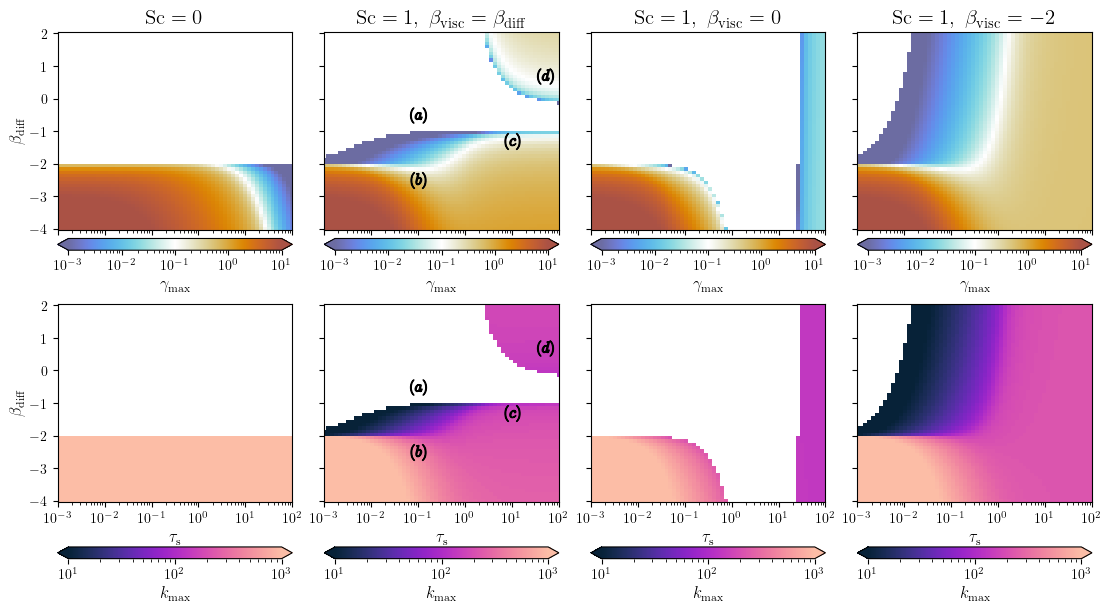

In [66]:
# %% plotting gamma_max and k_max with log colorbars and masked stable regions

cmap1 = cmr.prinsenvlag_r

#cmap1 = cmr.ocean_r
cmap2 = cmr.bubblegum


import matplotlib as mpl

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

panel_titles = [
    r"$\mathrm{Sc}=0$",
    r"$\mathrm{Sc}=1,\ \beta_{\rm visc}=\beta_{\rm diff}$",
    r"$\mathrm{Sc}=1,\ \beta_{\rm visc}=0$",
    r"$\mathrm{Sc}=1,\ \beta_{\rm visc}=-2$",
]

fig, axes = plt.subplots(
    2, 4, figsize=(11, 6),
    sharex=True, sharey=True,
    constrained_layout=True
)

# --- prepare positive-only arrays for log scaling ---

# gamma: only strictly positive values
gamma_pos = np.where(gamma_maps > 0.0, gamma_maps, np.nan)
gamma_vmin = np.nanmin(gamma_pos)
gamma_vmax = np.nanmax(gamma_pos)

gamma_vmin = 0.001
gamma_vmax = 10

# k_max: already NaN where stable by construction
k_pos = np.where(np.isfinite(kmax_maps) & (kmax_maps > 0.0), kmax_maps, np.nan)
kmin_plot = np.nanmin(k_pos)
kmax_plot = np.nanmax(k_pos)

for p in range(4):

    # -------- top row: gamma_max --------
    ax = axes[0, p]

    # mask stable regions (gamma <= 0) as NaN → white
    data_gamma = gamma_maps[p].copy()
    data_gamma[data_gamma <= 0.0] = np.nan

    im = ax.pcolormesh(
        tau_vals,
        beta_vals,
        data_gamma,
        shading="auto",
        norm=LogNorm(vmin=gamma_vmin, vmax=gamma_vmax),
        cmap=cmap1,
        rasterized=True
    )
    #im.set_rasterized(False)
    ax.set_xscale("log")
    ax.set_xlim(tau_vals[0], tau_vals[-1])
    ax.set_title(panel_titles[p], fontsize=15)
    if p == 0:
        ax.set_ylabel(r"$\beta_{\rm diff}$", fontsize=12)

    cbar = fig.colorbar(im, ax=ax, pad=0.01, extend = 'both', location='bottom')
    cbar.set_label(r"$\gamma_{\max}$", fontsize=12)
    


    # -------- bottom row: k_max --------
    ax2 = axes[1, p]

    data_k = kmax_maps[p].copy()   # already NaN where stable
    im2 = ax2.pcolormesh(
        tau_vals,
        beta_vals,
        data_k,
        shading="auto",
        norm=LogNorm(vmin=kmin_plot, vmax=kmax_plot),
        cmap=cmap2,
        rasterized=True
    )
    #im2.set_rasterized(False)
    ax2.set_xscale("log")
    ax2.set_xlim(tau_vals[0], tau_vals[-1])
    if p == 0:
        ax2.set_ylabel(r"$\beta_{\rm diff}$", fontsize=12)
    ax2.set_xlabel(r"$\tau_{\rm s}$", fontsize=12)

    cbar2 = fig.colorbar(im2, ax=ax2, pad=0.01, extend = 'both', location='bottom')
    cbar2.set_label(r"$k_{\max}$", fontsize=12)

    if p == 1:
        for a in [ax, ax2]:
            a.scatter([0.1], [-0.5], color = 'black', marker = r'$(a)$', s = 130)
            a.scatter([0.1], [-2.5], color = 'black', marker = r'$(b)$', s = 130)
            a.scatter([10], [-1.3], color = 'black', marker = r'$(c)$', s = 130)
            a.scatter([50], [0.7], color = 'black', marker = r'$(d)$', s = 130)
            

FIGURE_PATH = ROOT / "figures"; FIGURE_PATH.mkdir(exist_ok=True)
fig.savefig(FIGURE_PATH / "evp.pdf", bbox_inches="tight")
plt.show()